In [1]:
import nltk
import pickle
from collections import Counter
# have to install coco dataset from https://github.com/pdollar/coco.git
from pycocotools.coco import COCO
import argparse

In [2]:
class Vocabulary(object):
    """ simple one hot encoder for word"""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
        
    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1
            
    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unknown>']
        return self.word2idx[word]
    
    def __len__(self):
        return len(self.word2idx)

In [3]:
def build_vocab(json, threshold=2):
    coco = COCO(json)
    counter = Counter()
    ids = coco.anns.keys()
    for i, id in enumerate(ids):
        caption = str(coco.anns[id]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)
        
        if i%1000 == 0:
            print("{}/{} tokenized the captions".format(i, len(ids)))
    words = [word for word, cnt in counter.items() if cnt >= threshold]
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unknown>')
    
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab


In [4]:
def main(args):
    vocab = build_vocab(json=args.caption_path, threshold=args.threshold)
    vocab_path = args.vocab_path
    with open(vocab_path, 'wb') as f:
        pickle.dump(vocab, f)
    print("total vocabulary size is {}".format(len(vocab)))
    print("vocab saved to  {}".format(vocab_path))

In [5]:
# if __name__=='__main__':
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--caption_path',type=str,
#                        default='../data/captions_train2014.json', help='path for training annotations')
#     parser.add_argument('--vocab_path',type=str,
#                        default='../data/vocab.pkl', help='path for saveing vocabulary')
#     parser.add_argument('--caption_path',type=int,
#                        default=2, help='minimum word count threshold')
    
#     args = parser.parse_args()
#     main(args)
    

In [6]:
# nltk.download('punkt')

In [7]:
# vocab = build_vocab(json="../data/annotations/captions_train2014.json")

In [8]:
# vocab_path = "../data/vocab.pkl"
# with open(vocab_path, 'wb') as f:
#     pickle.dump(vocab, f)
# # print("total vocabulary size is {}".format(len(vocab)))
# print("vocab saved to  {}".format(vocab_path))

In [5]:
import torch 
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
from torch.autograd import Variable

In [29]:
class Encoder(nn.Module):
    def __init__(self, embed_size):
        super(Encoder, self).__init__()
        resnet = models.resnet101(pretrained=True)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        self.init_weights()
        
    def init_weights(self):
        self.linear.weight.data.normal_(0.0,0.02)
        self.linear.bias.data.fill_(0)
    
    def forward(self, images):
        features = self.resnet(images)
        features = Variable(features.data)
        features = features.view(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features
    
class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.init_weights()
    
    def init_weights(self):
        self.embed.weight.data.uniform_(-0.1,0.1)
        self.linear.weight.data.uniform_(-0.1,0.1)
        self.linear.bias.data.fill_(0)
    
    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True)
        hiddens,_ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(20):
            hiddens, states = self.lstm(inputs, states)
            outputs = self.linear(hiddens.squeeze(1))
            predicted = outputs.max(1)[1]
#             print(predicted)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)
#             print(inputs.size())
            inputs = inputs.unsqueeze(1)
#             print(inputs.size())
#         print(len(sampled_ids))
        sampled_ids = torch.cat(sampled_ids, 0)
        return sampled_ids.squeeze()

In [7]:
import torch
import torchvision.transforms as transform
import torch.utils.data as data
import os
import pickle
import numpy as np
import nltk
from PIL import Image
from pycocotools.coco import COCO

In [9]:
class DataSet(data.Dataset):
    def __init__(self, path, json, vocab, transform=None):
        self.path = path
        self.coco = COCO(json)
        self.ids = list(self.coco.anns.keys())
        self.vocab = vocab
        self.transform = transform
        
    def __getitem__(self, index):
        ann_id = self.ids[index]
        coco = self.coco
        caption = coco.anns[ann_id]['caption']
        img_id = coco.anns[ann_id]['image_id']
        img_name = coco.loadImgs(img_id)[0]['file_name']
        
        image = Image.open(os.path.join(self.path,img_name)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target
    
    def __len__(self):
        return len(self.ids)

In [10]:
def collate_fn(data):
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)
    images = torch.stack(images, 0)
    
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i,:end] = cap[:end]
    return images, targets, lengths
    

In [11]:
def get_loader(path, json, vocab, transform, batch_size, shuffle):
    coco = DataSet(path=path,json=json,vocab=vocab,transform=transform)
    data_loader = torch.utils.data.DataLoader(dataset=coco,
                                             batch_size=batch_size,
                                             shuffle=shuffle,
                                             collate_fn=collate_fn)
    return data_loader

In [89]:
trans = transform.Compose([
    transform.RandomCrop(224),
    transform.RandomHorizontalFlip(),
    transform.ToTensor(),
    transform.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

In [78]:
with open("../data/vocab.pkl", 'rb') as f:
    vocab = pickle.load(f)
dataloader = get_loader("../data/train2014/", "../data/annotations/captions_train2014.json",
         vocab, trans,2, shuffle=True)

loading annotations into memory...
Done (t=0.77s)
creating index...
index created!


In [79]:
# i = 0
# for i, (img, tar, lens) in enumerate(dataloader):
#     if (i > 1):
#         break
#     print(img)
#     print(tar)
#     print(lens)

In [80]:
import os
from PIL import Image

In [81]:
def resize_image(image, size):
    return image.resize(size, Image.ANTIALIAS)

def resize_images(image_dir, resized_dir, size):
    images = os.listdir(image_dir)
    num_images = len(images)
    for i, image in enumerate(images):
        with open(os.path.join(image_dir, image), 'r+b') as f:
            with Image.open(f) as img:
                img = resize_image(img, [256,256])
                img.save(os.path.join(resized_dir, image), img.format)
            if i%100 == 0:
                print("{} of {} images are saved to {}".format(i, num_images, resized_dir))

In [82]:
# resize_images("../data/train2014/","../data/resized/", [256,256])

In [83]:
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence

In [84]:
def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, volatile=volatile)

In [85]:
encoder = Encoder(256)
decoder = Decoder(256,512, len(vocab),1)

if torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()

    criterion = nn.CrossEntropyLoss()
    params = list(decoder.parameters()) + list(encoder.parameters()) + list(encoder.bn.parameters())
    optimizer = torch.optim.Adam(params, lr=0.001)
    
    total_step = len(dataloader)
    for epoch in range(5):
        for i, (images, captions, lengths) in enumerate(dataloader):
            images = to_var(images, volatile=True)
            captions = to_var(captions)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
            decoder.zero_grad()
            encoder.zero_grad()
            features = encoder(images)
            
            outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            if i%10 == 0:
                print("Epoch {} step {}, Loss: {}, Perplexity: {}".format(epoch, i, loss.data[0], np.exp(loss.data[0])))
            if (i+1)%100 == 0:
                torch.save(decoder.state_dict(), os.path.join("./",'decoder-{}-{}.pkl'.format(epoch, i+1)))
                torch.save(encoder.state_dict(), os.path.join("./",'encoder-{}-{}.pkl'.format(epoch, i+1)))
                
            

Epoch 0 step 0, Loss: 9.575478553771973, Perplexity: 14407.130747150946
Epoch 0 step 10, Loss: 7.931044101715088, Perplexity: 2782.3303243317773
Epoch 0 step 20, Loss: 7.958020210266113, Perplexity: 2858.40829953913
Epoch 0 step 30, Loss: 6.313075542449951, Perplexity: 551.7392394974356
Epoch 0 step 40, Loss: 6.3804402351379395, Perplexity: 590.1874717386665
Epoch 0 step 50, Loss: 5.062223434448242, Perplexity: 157.9412983319652
Epoch 0 step 60, Loss: 5.977242469787598, Perplexity: 394.35143147085586
Epoch 0 step 70, Loss: 4.635253429412842, Perplexity: 103.05403160883226
Epoch 0 step 80, Loss: 6.8426618576049805, Perplexity: 936.979925333512
Epoch 0 step 90, Loss: 4.684004783630371, Perplexity: 108.20253377265335
Epoch 0 step 100, Loss: 5.07065486907959, Perplexity: 159.27859982722507
Epoch 0 step 110, Loss: 4.659279823303223, Perplexity: 105.56003289968969
Epoch 0 step 120, Loss: 4.457162857055664, Perplexity: 86.24247942658428
Epoch 0 step 130, Loss: 4.745378494262695, Perplexity: 1

KeyboardInterrupt: 

In [12]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import os
from torch.autograd import Variable
from torchvision import transforms
from PIL import Image

In [13]:
def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, volatile=volatile)

In [14]:
def load(image_path, transform=None):
    image = Image.open(image_path).convert("RGB")
    image = image.resize([224,224], Image.LANCZOS)
    if transform is not None:
        image = transform(image).unsqueeze(0)
    return image

In [15]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])
with open("../data/vocab.pkl",'rb') as f:
    vocab = pickle.load(f)

In [30]:
encoder = Encoder(256)
encoder.eval()
decoder = Decoder(256,512, len(vocab),1)

In [31]:
encoder.load_state_dict(torch.load("../output/encoder-4-3000.pkl"))
decoder.load_state_dict(torch.load("../output/decoder-3-3000.pkl"))

In [71]:
path = "../data/val2014/COCO_val2014_000000000730.jpg"
image = load(path, transform=trans)
image_tensor = to_var(image, volatile=True)

In [72]:
if torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()

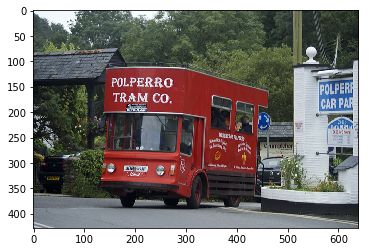

In [73]:
feature = encoder(image_tensor)
sampled_ids = decoder.sample(feature)
image = Image.open(path)
plt.imshow(np.asarray(image))
plt.show()

In [74]:
ids = sampled_ids.cpu().data.numpy()
sampled_caption = []
for word_id in ids:
    word = vocab.idx2word[word_id]
    sampled_caption.append(word)
    if (word == '<end>'):
        break
sentence = ' '.join(sampled_caption)
print(sentence)

<start> a red double decker bus driving down a street . <end>


In [91]:
def generator(path, json, vocab, transform, batch_size):
    coco = COCO(json)
    ids = list(coco.anns.keys())
    data_len = len(ids)
    for i in range(0, data_len, batch_size):
        start = i
        end = min(data_len, start+batch_size)
        out_ids = ids[start:end]
        img_list = []
        caption_list = []
        len_list = []
        for ann_id in out_ids:
            caption = coco.anns[ann_id]['caption']
            img_id = coco.anns[ann_id]['image_id']
            imgpath = coco.loadImgs(img_id)[0]['file_name']
            image = Image.open(os.path.join(path, imgpath)).convert('RGB')
            print(image)
            if transform is not None:
                image = transform(image)           
            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(vocab('<start>'))
            caption.extend([vocab(token) for token in tokens])
            caption.append(vocab('<end>'))
            target = torch.Tensor(caption)
            img_list.append(image)
            caption_list.append(target)
            len_list.append(len(caption))
        imgs = torch.stack(img_list,  0)
        target = torch.stack(caption_list, 0)
        return imgs, target, len_list

In [93]:
ge = generator("../data/resized/", "../data/annotations/captions_train2014.json",vocab, trans, 2)

loading annotations into memory...
Done (t=0.76s)
creating index...
index created!
<PIL.Image.Image image mode=RGB size=256x256 at 0x7FE4F94E1EB8>
<PIL.Image.Image image mode=RGB size=256x256 at 0x7FE4F94E1710>


RuntimeError: inconsistent tensor sizes at /opt/conda/conda-bld/pytorch_1502009910772/work/torch/lib/TH/generic/THTensorMath.c:2709

In [ ]:
class attn_Encoder(nn.Module):
    def __init__(self, embed_size):
        super(Encoder, self).__init__()
        resnet = models.resnet101(pretrained=True)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        self.init_weights()
        
    def init_weights(self):
        self.linear.weight.data.normal_(0.0,0.02)
        self.linear.bias.data.fill_(0)
    
    def forward(self, images):
        features = self.resnet(images)
        features = Variable(features.data)
        features = features.view(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features
    
class attn_Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.init_weights()
    
    def init_weights(self):
        self.embed.weight.data.uniform_(-0.1,0.1)
        self.linear.weight.data.uniform_(-0.1,0.1)
        self.linear.bias.data.fill_(0)
    
    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True)
        hiddens,_ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(20):
            hiddens, states = self.lstm(inputs, states)
            outputs = self.linear(hiddens.squeeze(1))
            predicted = outputs.max(1)[1]
#             print(predicted)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)
#             print(inputs.size())
            inputs = inputs.unsqueeze(1)
#             print(inputs.size())
#         print(len(sampled_ids))
        sampled_ids = torch.cat(sampled_ids, 0)
        return sampled_ids.squeeze()